This notebook shows how to access data stored by mesh simulations.

In [1]:
import logging
import os

import simulacra as si
import simulacra.units as u

import ionization as ion

LOGMAN = si.utils.LogManager('simulacra', 'ionization', stdout_level = logging.INFO)
THIS_DIR = os.getcwd()
OUT_DIR = os.path.join(THIS_DIR, 'out', 'mesh_datastores')

PLOT_KWARGS = dict(
    show = True,
    save = True,
    target_dir = OUT_DIR,
    fig_dpi_scale = 1.5,
)

%matplotlib inline

In [2]:
with LOGMAN as logger:
    potential = ion.potentials.Rectangle(
        start_time = 10 * u.asec,
        end_time = 40 * u.asec,
        amplitude = 1 * u.atomic_electric_field,
    )
    potential += ion.potentials.Rectangle(
        start_time = 60 * u.asec,
        end_time = 90 * u.asec,
        amplitude = -1 * u.atomic_electric_field,
    )

    sim = ion.mesh.SphericalHarmonicSpecification(
        'test',
        r_bound = 50 * u.bohr_radius,
        r_points = 500,
        l_bound = 100,
        time_initial = 0 * u.asec,
        time_final = 100 * u.asec,
        time_step = 1 * u.asec,
        electric_potential = potential,
        evolution_method = ion.mesh.SphericalHarmonicSplitOperator(),
        use_numeric_eigenstates = False,
        test_states = [
            ion.states.HydrogenBoundState(n, l)
            for n in range(1, 3) for l in range(n)
        ],
        datastores = (
            ion.mesh.Fields(),
            ion.mesh.Norm(),
            ion.mesh.InnerProducts(),
            ion.mesh.RExpectationValue(),
            ion.mesh.ZExpectationValue(),
            ion.mesh.InternalEnergyExpectationValue(),
            ion.mesh.TotalEnergyExpectationValue(),
        ),
    ).to_sim()

    sim.run(progress_bar = True)

18-02-22 09:45:03 [INFO] ~ Initialized SphericalHarmonicSpecification(name = test, file_name = test, uuid = 1021b471-29f4-457b-a371-09225c081a5c)
18-02-22 09:45:03 [INFO] ~ Initialized SphericalHarmonicSimulation(name = test, file_name = test, uuid = bd890aa1-3f5a-4d4c-a9ab-14e1acedbe0f)
18-02-22 09:45:03 [INFO] ~ Performing time evolution on SphericalHarmonicSimulation(test) {initialized}, starting from time index 0


100%|#########################################| 100/100 [00:03<00:00, 28.60it/s]


18-02-22 09:45:07 [INFO] ~ Finished performing time evolution on SphericalHarmonicSimulation(test) {finished}


We can access the collected data through the `data` attribute on the simulation. Everything is in numpy arrays, indexed by time.

In [3]:
print(sim.data.times / u.asec)
print(sim.data.norm)

[   0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.   27.   28.   29.   30.   31.   32.
   33.   34.   35.   36.   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.   60.   61.   62.   63.   64.   65.
   66.   67.   68.   69.   70.   71.   72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.   97.   98.
   99.  100.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.

These are some basic plots for various quantities - they're not formatted as nicely as the simulation's own plotting methods, but we're seeing the data access manually. For simplicity, all the y-axes are in generic atomic units.

In [4]:
def plot_fields(sim):
    si.vis.xy_plot(
        'fields',
        sim.data.times,
        sim.data.electric_field_amplitude / u.atomic_electric_field,
        sim.data.vector_potential_amplitude * u.proton_charge / u.atomic_momentum,
        line_labels = [
            r'$ \mathcal{E}(t) $',
            r'$ e \, \mathcal{A}(t) $',
        ],
        x_label = r'$ t $',
        x_unit = 'asec',
        title = 'Electric Field and Vector Potential',
        **PLOT_KWARGS
    )


def plot_norm_and_inner_products(sim):
    si.vis.xy_plot(
        'norm_and_inner_products',
        sim.data.times,
        sim.data.norm,
        sim.data.initial_state_overlap,
        *[ip for ip in sim.data.state_overlaps.values()],
        line_labels = [
            r'$ \left\langle \Psi | \Psi \right\rangle $',
            r'$ \left| \left\langle \Psi | \Psi(t = 0) \right\rangle \right|^2 $',
            *[rf'$ \left| \left\langle \Psi | {s.latex} \right\rangle \right|^2 $' for s in sim.data.inner_products.keys()],
        ],
        line_kwargs = [
            None,
            None,
            *[{'linestyle': '--'} for _ in range(len(sim.data.inner_products))],
        ],
        x_label = r'$ t $',
        x_unit = 'asec',
        title = r'Wavefunction Norm and Inner Products',
        **PLOT_KWARGS
    )


def plot_r_and_z_expectation_values(sim):
    si.vis.xy_plot(
        'r_and_z_expectation_values',
        sim.data.times,
        sim.data.r_expectation_value,
        sim.data.z_expectation_value,
        sim.data.z_dipole_moment_expectation_value / u.proton_charge,
        line_labels = [
            r'$ \left\langle \widehat{r} \right\rangle $',
            r'$ \left\langle \widehat{z} \right\rangle $',
            r'$ \left\langle \widehat{d_z} \right\rangle / e$',
        ],
        x_label = r'$ t $',
        x_unit = 'asec',
        y_unit = 'bohr_radius',
        title = r'$r$ and $z$ Position Expectation Values',
        **PLOT_KWARGS
    )


def plot_energy_expectation_values(sim):
    si.vis.xy_plot(
        'energy_expectation_values',
        sim.data.times,
        sim.data.internal_energy_expectation_value,
        sim.data.total_energy_expectation_value,
        line_labels = [
            r'$ \left\langle \mathcal{H_0} \right\rangle $',
            r'$ \left\langle \mathcal{H} \right\rangle $',
        ],
        x_label = r'$ t $',
        x_unit = 'asec',
        y_unit = 'eV',
        title = 'Energy Expectation Values',
        **PLOT_KWARGS
    )

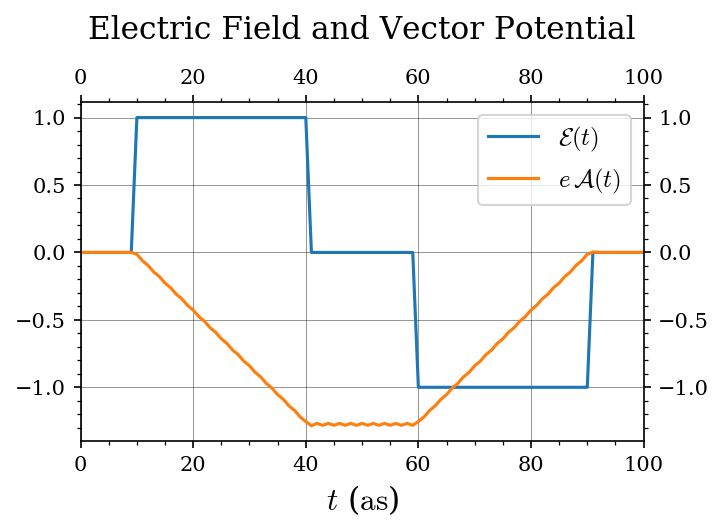

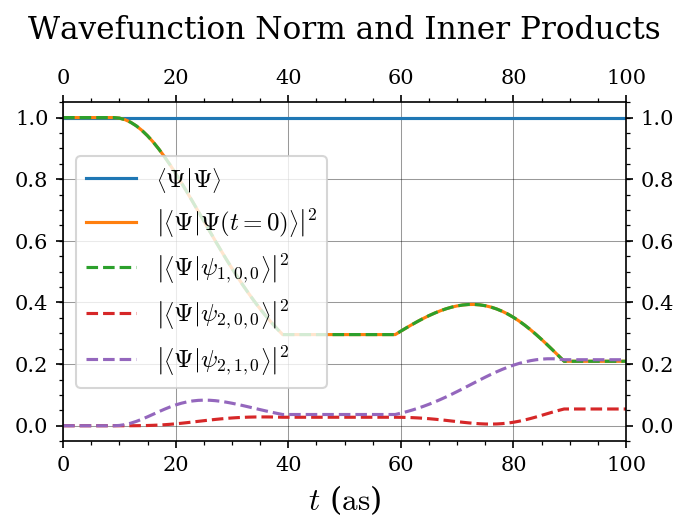

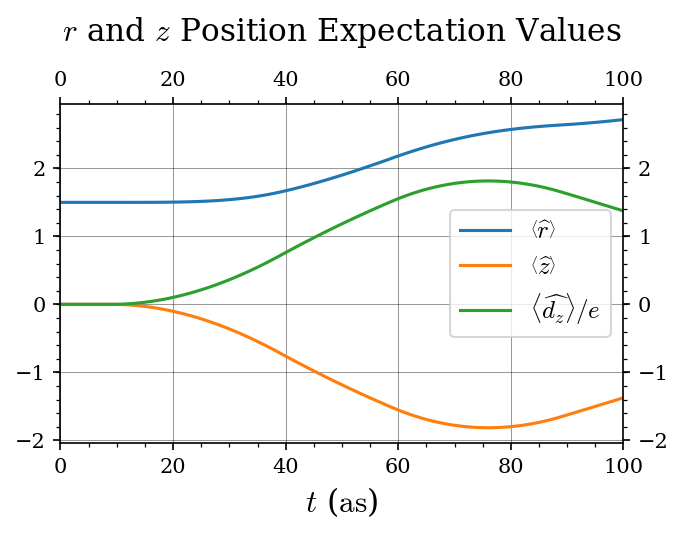

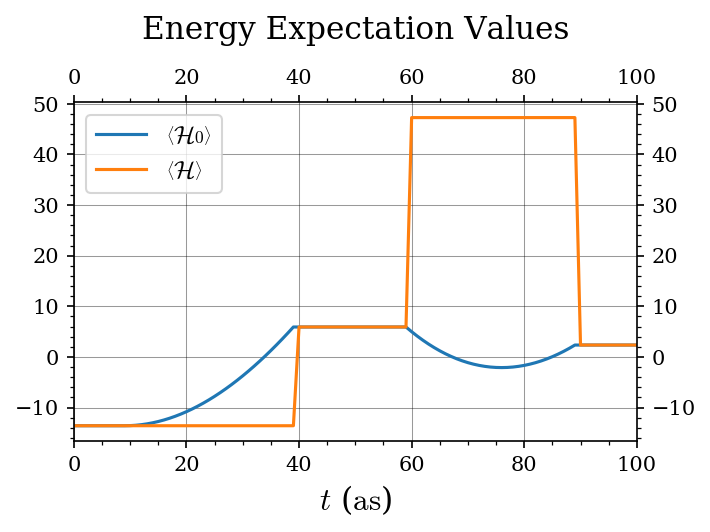

In [5]:
plot_fields(sim)
plot_norm_and_inner_products(sim)
plot_r_and_z_expectation_values(sim)
plot_energy_expectation_values(sim)